In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna import Trial
import random
import os
from tcn import TCN
from tensorflow.keras.layers import Input, Layer, Dense, Activation, Conv1D, Dropout, LayerNormalization, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [23]:
# Set fixed seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [24]:
# Load the dataset
df = pd.read_csv(r'filtered_data.csv')

# Drop any unnamed columns 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Set the 'time' column as the index of the DataFrame
df.set_index('time', inplace=True)

# Filter the time between 5:00 and 20:00
df = df.between_time('05:00', '20:00')

# Remove any rows with negative values in numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df = df[(df[numerical_columns] >= 0).all(axis=1)]

# View the cleaned dataset
print("First 5 rows of the cleaned dataset:")
display(df.head())

# Check for missing values in the cleaned dataset
print("Checking for missing values in the cleaned dataset:")
display(df.isnull().sum())

# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_filtered_data.csv')

First 5 rows of the cleaned dataset:


,total_solar_irradiance,direct_normal_irradiance,global_horizontal_irradiance,air_temperature,atmosphere,relative_humidity,power
time,,,,,,,
2019-01-01 05:00:00,1.0,240.0,1.0,0.5,1036.5,81.2,0.22
2019-01-01 05:15:00,1.0,240.0,1.0,0.6,1036.8,80.5,0.22
2019-01-01 05:30:00,1.0,240.0,1.0,0.7,1036.7,80.3,0.22
2019-01-01 05:45:00,1.0,240.0,1.0,0.7,1036.5,80.1,0.22
2019-01-01 06:00:00,1.0,240.0,1.0,0.7,1036.5,79.3,0.22


Cleaned dataset dimensions: (26404, 7)
Checking for missing values in the cleaned dataset:


total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64

In [25]:
# Define time intervals
train_start = '2019-01-01'
train_end = '2020-05-13'
val_start = '2020-05-14'
val_end = '2020-08-08'
test_start = '2020-08-09'
test_end = '2020-12-31'

# Split the data
train_df = df.loc[train_start:train_end]
val_df = df.loc[val_start:val_end]
test_df = df.loc[test_start:test_end]

# Display the shape of each set
print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (19290, 7)
Validation set: (3141, 7)
Test set: (3973, 7)


In [26]:
# It is important to observe that the data has been measured on different scales. Therefore, the normalization is performed by using MinMaxScaler of Scikit-learn,
# with a feature range from 0 to 1, to stabilize the learning performance without distorting the patterns in the data.

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_columns = train_df.select_dtypes(include=[np.number]).columns

# Fit the scaler on the training set. By applying fit_transform it will learn the mean and variance of the features of the training set
train_scaled = scaler.fit_transform(train_df[numeric_columns])

# Apply scaler.transform to validation and test sets
val_scaled = scaler.transform(val_df[numeric_columns])     # scaler.transform() makes sure the learned parameters from training set are then used to scale the validation set
test_scaled = scaler.transform(test_df[numeric_columns])   # scaler.transform() makes sure the learned parameters from training set are then used to scale the test set

# Convert back the scaled sets to dataframes with same index and columns
train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=numeric_columns)
val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=numeric_columns)
test_scaled = pd.DataFrame(test_scaled, index=test_df.index, columns=numeric_columns)

In [27]:
# Build create_sequences function, as a Temporal Convolutional Network requires inputs of a fixed size to learn temporal patterns

def create_sequences(data, target_column, time_steps=24, forecast_horizon=4):
    X, y, timestamps = [], [], []
    # -time_steps - forecast_horizon + 1 to avoid going out of the DataFrame boundaries
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        # Take a "window" of length time_steps
        X.append(data.iloc[i : i + time_steps].values)
        
        # Target values after forecast_horizon steps
        # Instead of just one value, we now predict the next 'forecast_horizon' values
        y.append(data.iloc[i + time_steps : i + time_steps + forecast_horizon][target_column].values)
        
        # Save the timestamp for the last predicted value in the horizon
        timestamps.append(data.index[i + time_steps + forecast_horizon - 1])
        
    return np.array(X), np.array(y), np.array(timestamps)

In [28]:
TIME_STEPS = 24  # Using the last 24 steps (6 hours) as "history"
FORECAST_HORIZON = 4  # Forecasting 4 steps ahead (1 hour, as each step is 15 minutes)

TARGET_COLUMN = 'power'

# Creating sequences for training data
X_train, y_train, _ = create_sequences(train_scaled, TARGET_COLUMN,
                                       time_steps=TIME_STEPS,
                                       forecast_horizon=FORECAST_HORIZON)

# Creating sequences for validation data
X_val, y_val, _ = create_sequences(val_scaled, TARGET_COLUMN,
                                   time_steps=TIME_STEPS,
                                   forecast_horizon=FORECAST_HORIZON)

# Creating sequences for test data
X_test, y_test, test_timestamps = create_sequences(test_scaled, TARGET_COLUMN,
                                                   time_steps=TIME_STEPS,
                                                   forecast_horizon=FORECAST_HORIZON)

# Print the shape of the sequences
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (19263, 24, 7), (19263, 4)
Validation data shape: (3114, 24, 7), (3114, 4)
Test data shape: (3946, 24, 7), (3946, 4)


In [31]:
# Create the residual block 
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # Convolution with dilated kernel
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)  # Apply dropout after the first convolution
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(conv1)
    
    # Add a residual connection
    residual = layers.Conv1D(filters, 1, padding='causal')(x)  
    x = layers.Add()([conv1, residual])
    x = layers.ReLU()(x)
    
    return x

# Build the TCN architecture
def build_tcn_model(input_shape, n_output, n_blocks=3, filters=64, kernel_size=3, dropout_rate=0.3, dilation_rates=None):
    if dilation_rates is None:
        dilation_rates = [2 ** i for i in range(n_blocks)]  # Default: exponential growth of dilation rates
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv1D(filters, kernel_size, padding='causal')(inputs)
    
    # Add multiple residual blocks with specified dilation rates
    for i in range(n_blocks):
        dilation_rate = dilation_rates[i]  # Get the corresponding dilation rate
        x = residual_block(x, filters, kernel_size, dilation_rate, dropout_rate)
    
    # Global average pooling to reduce dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Apply dropout to the dense layer 
    outputs = layers.Dense(n_output)(x)  # Output layer for multi-output regression
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model



In [33]:
# Objective function for Optuna

def objective(trial):
    # Hyperparameter tuning
    nb_filters = trial.suggest_categorical('nb_filters', [16, 32, 64, 128])  # Number of filters
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1) 
    kernel_size = trial.suggest_categorical('kernel_size', [2, 3, 5])  
    dilations = trial.suggest_categorical('dilations', [[1, 2, 4], [2, 4, 8]])  # Dilation rates
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256]) 
    
    # Build and compile the TCN model
    model = build_tcn_model(input_shape=X_train.shape[1:], 
                            n_output=y_train.shape[1],  
                            kernel_size=kernel_size,
                            dilation_rates=dilations,  
                            dropout_rate=dropout_rate)
    
    # Set the optimizer with the learning rate and gradient clipping
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    
    # Early stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    # Return the minimum validation loss for optimization
    val_loss = np.min(history.history['val_loss'])
    return val_loss

# Create a study with a specific name
study = optuna.create_study(study_name='TCN_hyperparameter_optimization', direction='minimize')

# Run the optimization for 10 trials
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)


[I 2025-01-06 02:50:36,161] A new study created in memory with name: TCNFI_hyperparameter_optimization
[I 2025-01-06 02:51:10,941] Trial 0 finished with value: 0.18303808569908142 and parameters: {'nb_filters': 64, 'dropout_rate': 0.24542422433388644, 'learning_rate': 0.057109639936358536, 'kernel_size': 3, 'dilations': [2, 4, 8], 'batch_size': 64}. Best is trial 0 with value: 0.18303808569908142.
[I 2025-01-06 02:52:17,262] Trial 1 finished with value: 0.0906330794095993 and parameters: {'nb_filters': 16, 'dropout_rate': 0.32037387026822284, 'learning_rate': 0.0054122054644177775, 'kernel_size': 5, 'dilations': [1, 2, 4], 'batch_size': 256}. Best is trial 1 with value: 0.0906330794095993.
[I 2025-01-06 02:52:44,167] Trial 2 finished with value: 0.18762537837028503 and parameters: {'nb_filters': 32, 'dropout_rate': 0.14944533426076287, 'learning_rate': 0.07359611090705889, 'kernel_size': 3, 'dilations': [2, 4, 8], 'batch_size': 256}. Best is trial 1 with value: 0.0906330794095993.
[I 2

Best hyperparameters: {'nb_filters': 16, 'dropout_rate': 0.32037387026822284, 'learning_rate': 0.0054122054644177775, 'kernel_size': 5, 'dilations': [1, 2, 4], 'batch_size': 256}


In [34]:
# Set fixed seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
import tensorflow as tf

# Combine training and validation sets for final retraining
combined_scaled = pd.concat([train_scaled, val_scaled])

# Create sequences
X_combined, y_combined, _ = create_sequences(combined_scaled, TARGET_COLUMN, TIME_STEPS)

y_combined = np.reshape(y_combined, (y_combined.shape[0], 4))  # Reshaping y for 4-step forecasting

# Define the residual block for the TCN
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # Convolution with dilated kernel
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)  # Apply dropout after the first convolution
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(conv1)
    
    # Add a residual connection
    residual = layers.Conv1D(filters, 1, padding='causal')(x)  
    x = layers.Add()([conv1, residual])
    x = layers.ReLU()(x)
    
    return x

# Define the TCN model with multiple residual blocks
def build_tcn_model(input_shape, n_output, nb_filters, kernel_size, dropout_rate, dilations, n_blocks=3):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution layer 
    x = layers.Conv1D(nb_filters, kernel_size, padding='causal')(inputs)
    
    # Add multiple residual blocks with increasing dilation rates
    for i in range(n_blocks):
        dilation_rate = dilations[i] if i < len(dilations) else 2 ** i  # Exponentially increasing dilation rate
        x = residual_block(x, nb_filters, kernel_size, dilation_rate, dropout_rate)
    
    # Global average pooling to reduce dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Apply dropout to the dense layer 
    outputs = layers.Dense(n_output)(x)  # Output layer for multi-output regression
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Manually pass the best parameters from the fine-tuning step to build the model
def build_model_with_best_params(input_shape, best_params):
    # Hyperparameters from Optuna
    nb_filters = best_params['nb_filters']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']
    kernel_size = best_params['kernel_size']
    dilations = best_params['dilations']
    batch_size = best_params['batch_size']

    # Set a default value for 'clip_norm' 
    clip_norm = best_params.get('gradient_clipping', 1.0)  # Default 

    # Build and compile the TCN model with the best parameters
    model = build_tcn_model(input_shape=input_shape, 
                            n_output=y_combined.shape[1], 
                            nb_filters=nb_filters,  
                            kernel_size=kernel_size,
                            dilations=dilations,
                            dropout_rate=dropout_rate)

    # Set the optimizer with the learning rate and gradient clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clip_norm)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])  
    
    return model

# Build model with the best hyperparameters
model = build_model_with_best_params(input_shape=(X_combined.shape[1], X_combined.shape[2]), best_params=best_params)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with combined data and early stopping
history = model.fit(X_combined, y_combined, epochs=30, batch_size=best_params['batch_size'], validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1751 - mae: 0.1751 - val_loss: 0.1327 - val_mae: 0.1327
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1109 - mae: 0.1109 - val_loss: 0.1280 - val_mae: 0.1280
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0995 - mae: 0.0995 - val_loss: 0.1342 - val_mae: 0.1342
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0941 - mae: 0.0941 - val_loss: 0.1264 - val_mae: 0.1264
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0947 - mae: 0.0947 - val_loss: 0.1257 - val_mae: 0.1257
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0927 - mae: 0.0927 - val_loss: 0.1367 - val_mae: 0.1367
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0983 - mae: 0.0983 - val_loss: 0.1024 - val_mae: 0.1024
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0831 - mae: 0.0831 - val_loss: 0.1172 - val_mae: 0.1172
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.090

In [39]:
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_220 (Conv1D) │ (None, 24, 16)    │        576 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_221 (Conv1D) │ (None, 24, 16)    │      1,296 │ conv1d_220[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_132 (ReLU)    │ (None, 24, 16)    │          0 │ conv1d_221[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 24, 16)    │          0 │ re_lu_132[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_222 (Conv1D) │ (None, 24, 16)    │      1,296 │ dropout_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_223 (Conv1D) │ (None, 24, 16)    │        272 │ conv1d_220[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_66 (Add)        │ (None, 24, 16)    │          0 │ conv1d_222[0][0], │
│                     │                   │            │ conv1d_223[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_133 (ReLU)    │ (None, 24, 16)    │          0 │ add_66[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_224 (Conv1D) │ (None, 24, 16)    │      1,296 │ re_lu_133[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_134 (ReLU)    │ (None, 24, 16)    │          0 │ conv1d_224[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 24, 16)    │          0 │ re_lu_134[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_225 (Conv1D) │ (None, 24, 16)    │      1,296 │ dropout_89[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_226 (Conv1D) │ (None, 24, 16)    │        272 │ re_lu_133[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_67 (Add)        │ (None, 24, 16)    │          0 │ conv1d_225[0][0], │
│                     │                   │            │ conv1d_226[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_135 (ReLU)    │ (None, 24, 16)    │          0 │ add_67[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_227 (Conv1D) │ (None, 24, 16)    │      1,296 │ re_lu_135[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_136 (ReLU)    │ (None, 24, 16)    │          0 │ conv1d_227[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 24, 16)    │          0 │ re_lu_136[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_228 (Conv1D) │ (None, 24, 16)    │      1,296 │ dropout_90[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_229 (Conv1D) │ (None, 24, 16)    │        272 │ re_lu_135[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_68 (Add)        │ (None, 24, 16)    │          0 │ conv1d_228[0][0]

 Total params: 35,582 (139.00 KB)

 Trainable params: 11,860 (46.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,722 (92.67 KB)

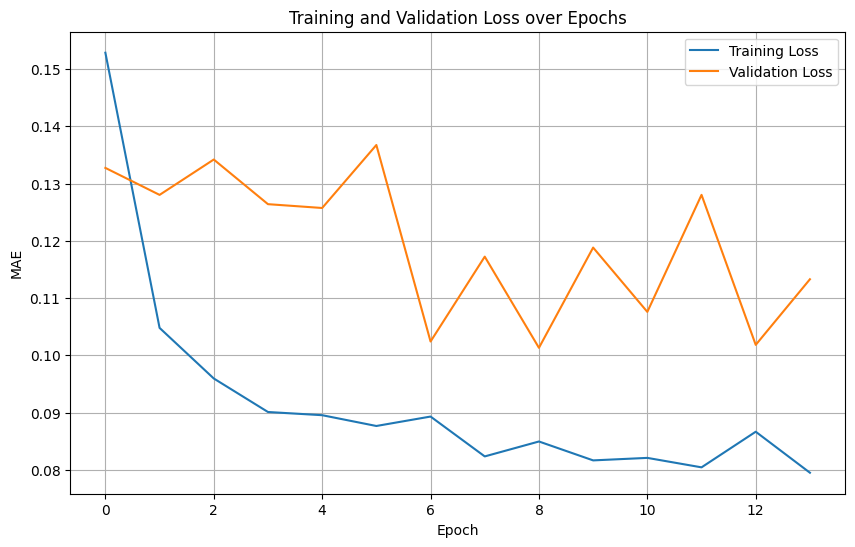

In [40]:
# Plot the training loss vs validation loss across epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig('TCN_training_validation_loss.png', dpi=300)
plt.show()

In [41]:
# Inverse scaling for y_pred_train (predicted values on training set)
y_pred_train = model.predict(X_train)

# Only select the predicted target values 
y_pred_train_target = y_pred_train[:, 0]  

# Inverse scaling only on the target values (predicted power)
y_pred_train_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_train_target), len(numeric_columns) - 1)), y_pred_train_target]))[:, -1] 

# Inverse scaling for y_train (actual training set values)
train_inv = scaler.inverse_transform(train_scaled)
train_inv = pd.DataFrame(train_inv, columns=numeric_columns, index=train_scaled.index)
y_train_inv = train_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip initial `TIME_STEPS`

# Inverse scaling for y_val (actual values on validation set)
val_inv = scaler.inverse_transform(val_scaled)
val_inv = pd.DataFrame(val_inv, columns=numeric_columns, index=val_scaled.index)
y_val_inv = val_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Inverse scaling for y_pred_val (predicted values on validation set)
y_pred_val = model.predict(X_val)

# Only select the predicted target values
y_pred_val_target = y_pred_val[:, 0] 

# Inverse scaling only on the target values (predicted power)
y_pred_val_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_val_target), len(numeric_columns) - 1)), y_pred_val_target]))[:, -1] 

# Ensure that train_index and val_index are sliced properly for plotting
train_index = train_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_train_inv)]
val_index = val_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_val_inv)]

# Adjust y_train_inv and y_val_inv to match the sliced indices
y_train_inv = y_train_inv[:len(train_index)]
y_val_inv = y_val_inv[:len(val_index)]

# Adjust predicted values to match index lengths
y_pred_train_inv = y_pred_train_inv[:len(train_index)]
y_pred_val_inv = y_pred_val_inv[:len(val_index)]

602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


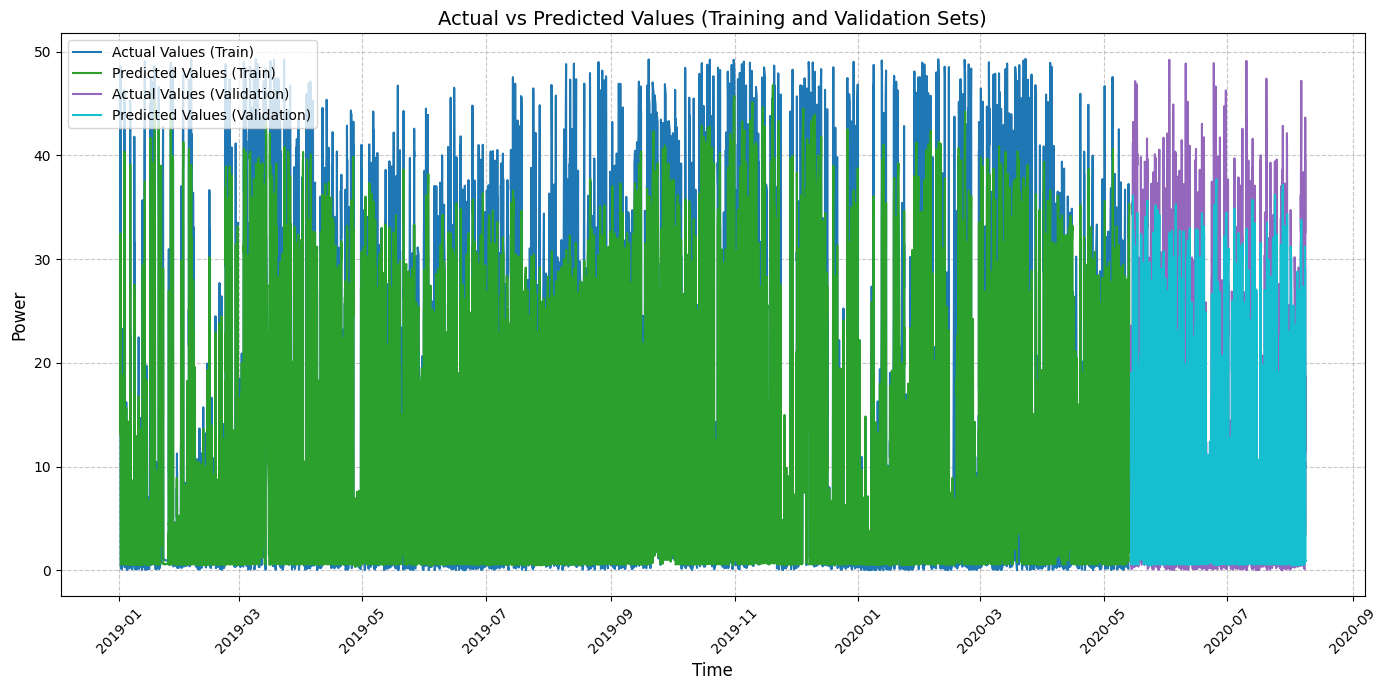

In [42]:
# Plot Actual vs Predicted Values for Training and Validation Sets
plt.figure(figsize=(14, 7))

# Color palette
train_actual_color = '#1f77b4' 
train_predicted_color = '#2ca02c'  
val_actual_color = '#9467bd'  
val_predicted_color = '#17becf' 

# Plot for Training Set
plt.plot(train_index, y_train_inv, label='Actual Values (Train)', color=train_actual_color)
plt.plot(train_index, y_pred_train_inv, label='Predicted Values (Train)', color=train_predicted_color)

# Plot for Validation Set
plt.plot(val_index, y_val_inv, label='Actual Values (Validation)', color=val_actual_color)
plt.plot(val_index, y_pred_val_inv, label='Predicted Values (Validation)', color=val_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Training and Validation Sets)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)

# Move the legend to the top-left corner
plt.legend(fontsize=10, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot at 300 dots per inch
plt.savefig("actual_vs_predicted_TCNFE.png", dpi=300)

# Show the plot
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Training Set Metrics
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
r2_train = r2_score(y_train_inv, y_pred_train_inv)

# Validation Set Metrics
mae_val = mean_absolute_error(y_val_inv, y_pred_val_inv)
rmse_val = np.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
r2_val = r2_score(y_val_inv, y_pred_val_inv)

# Print the Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R²: {r2_val:.4f}")

Training Set Metrics:
MAE: 2.8289
RMSE: 4.9926
R²: 0.8344

Validation Set Metrics:
MAE: 3.6152
RMSE: 5.3734
R²: 0.7652


In [44]:
# Prediction on test set
y_pred = model.predict(X_test)

# Only select the predicted target values 
y_pred_test_target = y_pred[:, 0] 

# Inverse scaling for y_pred_test (predicted values on test set)
y_pred_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_test_target), len(numeric_columns) - 1)), y_pred_test_target])
)[:, -1]  # Extract the target column only

# Inverse scaling for y_test (actual values on test set)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)
y_test_inv = test_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Align the test index
test_index = test_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_inv)]

# Ensure that y_test_inv and y_pred_inv have matching lengths for plotting
y_test_inv = y_test_inv[:len(test_index)]
y_pred_inv = y_pred_inv[:len(test_index)]

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


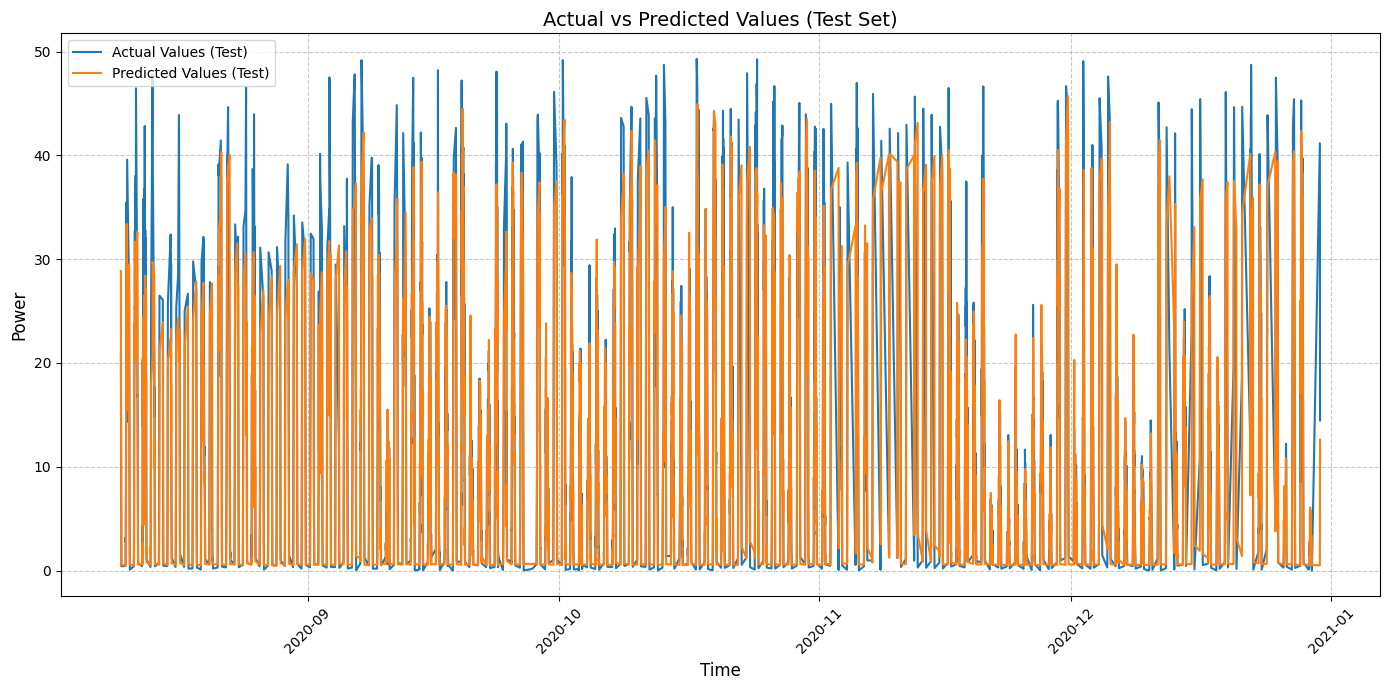

In [45]:
# Plot Actual vs Predicted Values for Test Set
plt.figure(figsize=(14, 7))

# Color palette 
test_actual_color = '#1f77b4' 
test_predicted_color = '#ff7f0e'

# Plot for Test Set
plt.plot(test_index, y_test_inv, label='Actual Values (Test)', color=test_actual_color)
plt.plot(test_index, y_pred_inv, label='Predicted Values (Test)', color=test_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Test Set)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot at 300 DPI
plt.savefig("actual_vs_predicted_test_TCN.png", dpi=300)

# Show the plot
plt.show()

In [46]:
from datetime import datetime 

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Save metrics to CSV
metrics = {
    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}

metrics_df = pd.DataFrame([metrics])
metrics_file = 'TCN_metrics.csv'

if not os.path.isfile(metrics_file):
    metrics_df.to_csv(metrics_file, index=False)
else:
    metrics_df.to_csv(metrics_file, mode='a', header=False, index=False)

print(f"Metrics saved to {metrics_file}")

MAE: 3.66
RMSE: 5.87
R²: 0.7581
Metrics saved to TCNFE_metrics.csv


In [47]:
model.save('TCN_model.h5')